In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [12]:
class LeakyIntegrateAndFireModel:
    def __init__(self, dt, t_init, T, vRest, vTh, tau_ref, vSpike, I, Rm, Cm, Vm = None):
        self.dt = dt  # Time step
        self.t_init = t_init  # Initial time
        self.T = T  # Total simulation time in mSec
        self.vRest = vRest  # Resting potential
        self.vTh = vTh  # Threshold voltage
        self.tau_ref = tau_ref  # Refractory period
        self.vSpike = vSpike  # Spike voltage
        self.I = I  # Input current
        self.Rm = Rm  # Membrane resistance
        self.Cm = Cm  # Membrane capacitance
        self.time = np.arange(0, T*1e-3 + dt*1e-3, dt*1e-3)  # Time array
        
        if Vm is not None:
            self.Vm = Vm
        else:
            self.Vm = np.ones(len(self.time))*vRest*1e-3  # Membrane potential
            
        self.tau_m = self.Rm * 1e3 * self.Cm * 1e-6  # Membrane time constant


    def simulate(self):
        # Update the time array based on T and dt
        self.time = np.arange(0, self.T * 1e-3 + self.dt * 1e-3, self.dt * 1e-3) 
        # Triangular stimulation
        self.stim = float(self.I) * 1e-3 * signal.windows.triang(len(self.time))
        
        # Array to hold spike times for each set of Rm and Cm values
        spikes = []
        tau_m = self.Rm * 1e3 * self.Cm * 1e-6
        Vm = np.ones(len(self.time)) * self.vRest * 1e-3  # Reset Vm for each simulation
        Vm, spikes = self.simulation_step(self.t_init, self.vRest, self.Rm, self.Cm, tau_m, self.vTh, self.vSpike, self.stim, self.time, Vm)
        self.neural_plot(self.time, Vm, self.stim, spikes, self.vTh)
        return Vm, spikes

    def simulation_step(self, t_init, vRest, Rm, Cm, tau_m, vTh, vSpike, stim, time, Vm):
        spikes = []
        for i, t in enumerate(time[:-1]):
            if t > t_init:
                uinf = vRest*1e-3 + Rm*1e3 * stim[i]
                Vm[i+1] = uinf + (Vm[i] - uinf) * np.exp(-self.dt * 1e-3 / tau_m)
                if Vm[i] >= vTh * 1e-3:
                    spikes.append(t * 1e3)
                    Vm[i] = vSpike * 1e-3
                    t_init = t + self.tau_ref * 1e-3
        return Vm, spikes

    def neural_plot(self, time, Vm, stim, spikes, vTh):
        plt.figure(figsize=(10, 5))
        plt.title('Leaky Integrate-and-Fire Model', fontsize=15)
        plt.ylabel('Membrane Potential (mV)', fontsize=15)
        plt.xlabel('Time (msec)', fontsize=15)
        plt.plot(time * 1e3, Vm * 1e3, linewidth=5, label='Vm')
        plt.plot(time * 1e3, 100 / max(stim) * stim, label='Stimuli (Scaled)', color='sandybrown', linewidth=2)
        plt.ylim([-75, 100])
        if spikes:
            plt.axvline(x=spikes[0], c='red', label='Spike')
            for s in spikes[1:]:
                plt.axvline(x=s, c='red')
        plt.axhline(y=vTh, c='black', label='Threshold', linestyle='--')
        plt.legend()
        plt.show()


First Step, try different currents and get subsequent frequencies.

ValueError: x and y must have same first dimension, but have shapes (502,) and (1,)

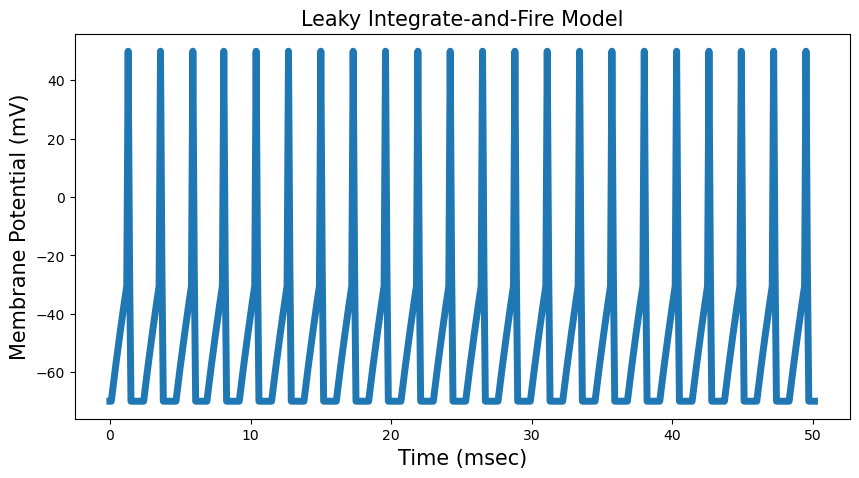

In [13]:
currents = [0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for current in currents:
    model = LeakyIntegrateAndFireModel(
        dt=0.1, t_init=0, T=50, vRest=-70, vTh=-30, tau_ref=1, vSpike=50, I=current, Rm=1.0, Cm=5.0
    )
    model.simulate()

In [ ]:

for spikes in spike_sims:
    spikes_freq = []
    for i in range(1, len(spikes)):
        spike_diff = spikes[i] - spikes[i-1]
        spike_freq = 1 / (spike_diff)  # spike frequency in milliseconds.
        spikes_freq.append(spike_freq)
    print(spikes_freq)

[0.2564102564102565, 0.32258064516129015, 0.35714285714285704, 0.4, 0.4166666666666669, 0.43478260869565205, 0.4166666666666669, 0.3846153846153844, 0.3448275862068963, 0.29411764705882365, 0.2]
[0.19607843137254904, 0.25, 0.28571428571428603, 0.303030303030303, 0.27027027027027006, 0.22727272727272735, 0.16393442622950816]
[0.1694915254237288, 0.20833333333333345, 0.22727272727272715, 0.18867924528301872, 0.13157894736842116]


Calculate I-F Curves

In [ ]:
spikes_stim

[7.450199203187251e-05,
 0.0001055776892430279,
 0.0001302788844621514,
 0.00015258964143426295,
 0.00017250996015936255,
 0.0001916334661354582,
 0.00019003984063745022,
 0.0001709163346613546,
 0.000150199203187251,
 0.00012709163346613547,
 0.0001,
 6.01593625498008e-05]

In [ ]:
# For each time in spikes, calculate the difference between the current and previous spike time and subsequently the frequency.
for i in range(1, len(spikes)):
    spike_diff = spikes[i] - spikes[i-1]
    spike_freq = 1 / (spike_diff)  # spike frequency in milliseconds.
    spikes_freq.append(spike_freq)

In [ ]:
spikes_freq

[0.2564102564102565,
 0.32258064516129015,
 0.35714285714285704,
 0.4,
 0.4166666666666669,
 0.43478260869565205,
 0.4166666666666669,
 0.3846153846153844,
 0.3448275862068963,
 0.29411764705882365,
 0.2]

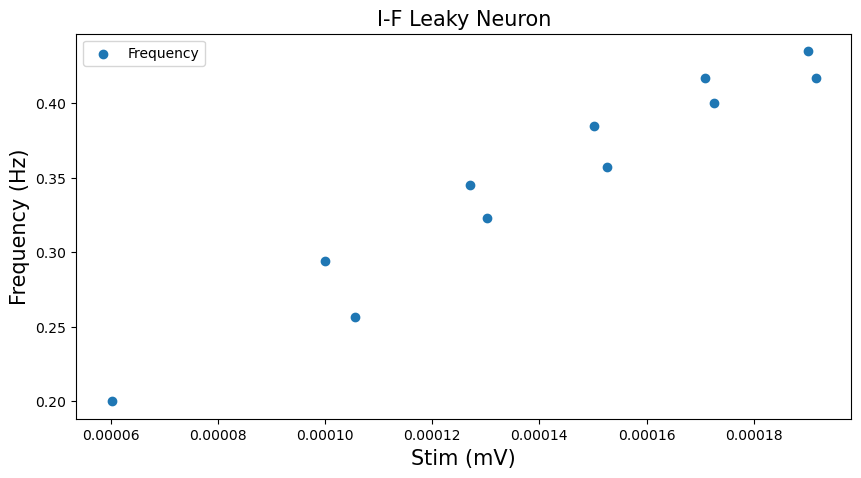

In [ ]:
plt.figure(figsize=(10,5))
plt.title('I-F Leaky Neuron', fontsize=15)
plt.ylabel('Frequency (Hz)', fontsize=15)
plt.xlabel('Stim (mV)', fontsize=15)
plt.scatter(spikes_stim[1:], spikes_freq, label='Frequency')
plt.legend()
plt.show()

V-T Relationship

/tmp/ipykernel_10872/2030711394.py:39: RuntimeWarning: divide by zero encountered in log
  t_th = -tau_m * np.log(1 - (V_th - V_rest) / (Rm * I))
/tmp/ipykernel_10872/2030711394.py:39: RuntimeWarning: invalid value encountered in log
  t_th = -tau_m * np.log(1 - (V_th - V_rest) / (Rm * I))


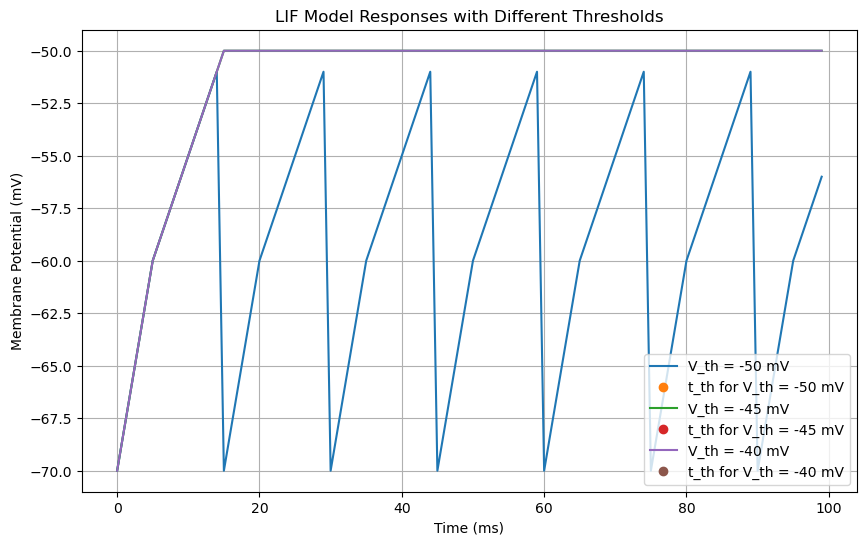